In [51]:
import numpy as np 
import _pickle as cPickle
import gzip
import os
from sklearn.utils import shuffle
from tqdm import tqdm

In [191]:
# utility functions

def one_hot_encoded(y, num_class):
    n = y.shape[0]
    onehot = np.zeros((n, num_class), dtype="int32")
    for i in range(n):
        idx = y[i]
        onehot[i][idx] = 1
    return onehot


def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)  # both are not one hot encoded


def softmax(x):
    # YOUR CODE HERE
    exp_x = np.exp(x - np.max(x, axis = 1, keepdims=True))
    return exp_x / np.sum(exp_x, axis = 1, keepdims=True)

# l2 regularization
def l2_reg(layers, lam=0.001):
    reg_loss = 0.0
    for layer in layers:
        if hasattr(layer, 'W'):
            reg_loss += 0.5 * lam * np.sum(layer.W * layer.W)
    return reg_loss


# l2 regularization grad
def delta_l2_reg(layers, grads, lam=0.001):
    for layer, grad in zip(layers, reversed(grads)):
        if hasattr(layer, 'W'):
            grad[0] += lam * layer.W
    return grads


In [192]:
# how to works eval_numerical_gradient:
f = lambda x: x**2
x = np.linspace(0, 1, 6).reshape(-1, 3)
print(f"x = {x}")
fx = f(x)
grad = np.zeros_like(x)
it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
print(f"it = {list(it)}")
it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])

while not it.finished:
    ix = it.multi_index
    print(x[ix])
    it.iternext()

x = [[0.  0.2 0.4]
 [0.6 0.8 1. ]]
it = [array(0.), array(0.2), array(0.4), array(0.6), array(0.8), array(1.)]
0.0
0.2
0.4
0.6000000000000001
0.8
1.0


In [193]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [194]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None # local gradient

    def forward(self, X, mode):
        # YOUR CODE HERE
        self.X = X
        return np.maximum(X, 0)
    
    def backward(self, dout, mode):
        # YOUR CODE HERE
        # we have to muotiply the negative value of dout to 0, and positiму to 1
       #  if len(self) > 1:
       #      self.gradInput = dout[0].copy()
       #  else:
       #      self.gradInput = dout[0].copy()
        self.gradInput = dout.copy()
        self.gradInput[self.X<0] = 0
        return self.gradInput, []

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 [])

In [197]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
print(points)
relu = ReLU()
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 12))
grads = relu.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[-1.         -0.98319328 -0.96638655 -0.94957983 -0.93277311 -0.91596639
  -0.89915966 -0.88235294 -0.86554622 -0.8487395  -0.83193277 -0.81512605]
 [-0.79831933 -0.78151261 -0.76470588 -0.74789916 -0.73109244 -0.71428571
  -0.69747899 -0.68067227 -0.66386555 -0.64705882 -0.6302521  -0.61344538]
 [-0.59663866 -0.57983193 -0.56302521 -0.54621849 -0.52941176 -0.51260504
  -0.49579832 -0.4789916  -0.46218487 -0.44537815 -0.42857143 -0.41176471]
 [-0.39495798 -0.37815126 -0.36134454 -0.34453782 -0.32773109 -0.31092437
  -0.29411765 -0.27731092 -0.2605042  -0.24369748 -0.22689076 -0.21008403]
 [-0.19327731 -0.17647059 -0.15966387 -0.14285714 -0.12605042 -0.1092437
  -0.09243697 -0.07563025 -0.05882353 -0.04201681 -0.02521008 -0.00840336]
 [ 0.00840336  0.02521008  0.04201681  0.05882353  0.07563025  0.09243697
   0.1092437   0.12605042  0.14285714  0.15966387  0.17647059  0.19327731]
 [ 0.21008403  0.22689076  0.24369748  0.2605042   0.27731092  0.29411765
   0.31092437  0.32773109  0.3445

In [198]:
class Linear():

    def __init__(self, in_size, out_size):

        # Xavier init
        self.W = np.random.randn(in_size, out_size) / np.sqrt(in_size + out_size/ 2.)
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X, mode):
        # YOUR CODE HERE
        self.X = X
        return X @ self.W + self.b
    
    def backward(self, dout, mode):
        # YOUR CODE HERE
        self.gradW = self.X.T @ dout  # dout: (batch_size, out))
        self.gradB = dout.sum(axis = 0)
        self.gradInput = dout @ self.W.T
        
        return self.gradInput, [self.gradW, self.gradB]

In [199]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
fc = Linear(12, 5)
f = lambda x: fc.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 5))
grads = fc.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[ 0.39352829  0.3015619  -0.11588615 -0.14879223 -0.10489994  0.08598445
   0.10976699  0.25164278  0.70753125  0.09415515 -0.48137056 -0.23873676]
 [ 0.39352829  0.3015619  -0.11588615 -0.14879223 -0.10489994  0.08598445
   0.10976699  0.25164278  0.70753125  0.09415515 -0.48137056 -0.23873676]
 [ 0.39352829  0.3015619  -0.11588615 -0.14879223 -0.10489994  0.08598445
   0.10976699  0.25164278  0.70753125  0.09415515 -0.48137056 -0.23873676]
 [ 0.39352829  0.3015619  -0.11588615 -0.14879223 -0.10489994  0.08598445
   0.10976699  0.25164278  0.70753125  0.09415515 -0.48137056 -0.23873676]
 [ 0.39352829  0.3015619  -0.11588615 -0.14879223 -0.10489994  0.08598445
   0.10976699  0.25164278  0.70753125  0.09415515 -0.48137056 -0.23873676]
 [ 0.39352829  0.3015619  -0.11588615 -0.14879223 -0.10489994  0.08598445
   0.10976699  0.25164278  0.70753125  0.09415515 -0.48137056 -0.23873676]
 [ 0.39352829  0.3015619  -0.11588615 -0.14879223 -0.10489994  0.08598445
   0.10976699  0.25164278  0.707

In [200]:
p.shape

(4, 2)

In [218]:
class CrossEntropyLoss(object):

    def forward(self, X, y):
        # YOUR CODE HERE
        self.size = X.shape[0]
        self.p = softmax(X)

        crossentropy = -np.log(self.p[range(self.size), y])
        return np.sum(crossentropy) / self.size
    
    def backward(self, X, y):
        # YOUR CODE HERE
        dx = self.p.copy()
        dx[range(self.size), y] -= 1
        dx /= self.size
        
        return dx

## NN implementation

In [219]:
class NN:

    def __init__(self, loss_func=CrossEntropyLoss(), mode='train'):
    
        self.layers = []
        self.params = []
        self.loss_func = loss_func
        self.grads = []
        self.mode = mode

    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X, self.mode)
        return X

    def backward(self, dout):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            dout, grad = layer.backward(dout, self.mode)
            self.grads.append(grad)
        return self.grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        dout = self.loss_func.backward(out,y)
        loss += l2_reg(self.layers)
        grads = self.backward(dout)
        grads = delta_l2_reg(self.layers, grads)
        return loss, grads

    def predict(self, X):
        X = self.forward(X)
        return np.argmax(softmax(X), axis=1)


    def dispGradParam():
        print(self.grads)
    

    def clear_grad_param(self):
        self.grads = []

In [220]:
# SGD with momentum
def update(velocity, params, grads, learning_rate=0.001, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]


# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    X, y = shuffle(X, y)

    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, ...]
        y_batch = y[i:i + minibatch_size, ...]

        minibatches.append((X_batch, y_batch))
        
    return minibatches


In [221]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9,
                 verbose=True, X_val=None, y_val=None, nesterov=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    c = 0 
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        if verbose:
            print("Epoch {0}".format(i + 1))

        # iterate over mini batches
        for X_mini, y_mini in tqdm(minibatches):

            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads,
                            learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in tqdm(minibatches_val):
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)


        # accuracy of model at end of epoch after all mini batch updates   

        if verbose:
            m_train = X_train.shape[0]
            m_val = X_val.shape[0]
            y_train_pred = np.array([], dtype="int64")
            y_val_pred = np.array([], dtype="int64")

            for i in range(0, m_train, minibatch_size):
                X_tr = X_train[i:i + minibatch_size, : ]
                y_tr = y_train[i:i + minibatch_size, ]
                y_train_pred = np.append(y_train_pred, net.predict(X_tr))

            for i in range(0, m_val, minibatch_size):
                X_va = X_val[i:i + minibatch_size, : ]
                y_va = y_val[i:i + minibatch_size, ]
                y_val_pred = np.append(y_val_pred, net.predict(X_va))

            train_acc = check_accuracy(y_train, y_train_pred)
            val_acc = check_accuracy(y_val, y_val_pred)

            mean_train_loss = sum(loss_batch) / float(len(loss_batch))
            mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))


            # early stopping with patience = 5 on val loss

            if len(val_loss_epoch) == 0:
                val_loss_epoch.append(mean_val_loss)
            else:
                for j in val_loss_epoch[-5:]:
                    if mean_val_loss > j:
                        c += 1
                    else:
                        c = 0
                if c > 5:
                    print('Early stopping')
                    return net
                else:
                    c = 0
                    val_loss_epoch.append(mean_val_loss)    


            print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(
                mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net


In [222]:
# Get preprocessed training and validation data

X_train = np.array([
    [1, 2, 1, 2],
    [2, 4, 2, 4],
    [2, 1, 2, 1],
    [4, 2, 4, 2],
])

y_train = np.array([0, 1, 0, 1])
X_val = X_train.copy()
y_val = y_train.copy()

print(X_train.shape)
print(X_val.shape)
y_val

(4, 4)
(4, 4)


array([0, 1, 0, 1])

In [214]:
model = NN()

# add some layers
# YOUR CODE HERE
model.add_layer(Linear(4, 4))
model.add_layer(ReLU())
model.add_layer(Linear(4, 2))
model.add_layer(ReLU())
model.params

[[array([[-0.59268453, -0.11430763, -0.23818685,  0.10326178],
         [-0.59805451, -0.3340309 ,  0.54827208, -0.74358331],
         [-0.14370706,  0.4508676 , -0.40187832, -0.23646897],
         [-0.65932071, -0.0734022 ,  0.05429025,  0.01541552]]),
  array([[0., 0., 0., 0.]])],
 [],
 [array([[-0.00291614,  0.17061565],
         [-0.40731326,  0.08105479],
         [ 0.52061921,  0.37514613],
         [ 1.18515271, -0.17408087]]),
  array([[0., 0.]])],
 []]

In [223]:
p = np.random.rand(4, 2)
p.shape

(4, 2)

In [224]:
np.log(p[:, [1, 1, 0, 0]])

array([[-0.57461393, -0.57461393, -2.73868631, -2.73868631],
       [-0.02421387, -0.02421387, -0.47771014, -0.47771014],
       [-2.35003018, -2.35003018, -0.61619462, -0.61619462],
       [-0.25528879, -0.25528879, -0.37591002, -0.37591002]])

In [225]:
model = train(model, X_train , y_train, minibatch_size=4, epoch=100,
           learning_rate=0.1, X_val=X_val, y_val=y_val)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Epoch 1
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.45247020793725146 | Training Accuracy = 1.0 | Val Loss = 0.44974173854606914 | Val Accuracy = 1.0
Epoch 2
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.44974173854606914 | Training Accuracy = 0.75 | Val Loss = 0.44914653463443227 | Val Accuracy = 0.75
Epoch 3
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.44914653463443227 | Training Accuracy = 0.75 | Val Loss = 0.4447232706739718 | Val Accuracy = 0.75
Epoch 4
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.4447232706739718 | Training Accuracy = 0.75 | Val Loss = 0.4413758938112421 | Val Accuracy = 0.75
Epoch 5
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.4413758938112421 | Training Accuracy = 0.75 | Val Loss = 0.4382727339120446 | Val Accuracy = 0.75
Epoch 6
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.4382727339120446 | Training Accuracy = 1.0 | Val Loss = 0

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 252.26it/s]

(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.3825059402322931 | Training Accuracy = 0.75 | Val Loss = 0.3902929698328773 | Val Accuracy = 0.75
Epoch 32
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.3902929698328773 | Training Accuracy = 1.0 | Val Loss = 0.37660022912678526 | Val Accuracy = 1.0
Epoch 33
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.37660022912678526 | Training Accuracy = 0.75 | Val Loss = 0.37731461321465487 | Val Accuracy = 0.75
Epoch 34
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.37731461321465487 | Training Accuracy = 1.0 | Val Loss = 0.3757825227154482 | Val Accuracy = 1.0
Epoch 35
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.3757825227154482 | Training Accuracy = 0.75 | Val Loss = 0.38227583408162386 | Val Accuracy = 0.75
Epoch 36
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.38227583408162386 | Training Accuracy = 1.0 | Val Loss = 0.369


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.23it/s]

(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.3236751875649158 | Training Accuracy = 1.0 | Val Loss = 0.3156086805728108 | Val Accuracy = 1.0
Epoch 59
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.3156086805728108 | Training Accuracy = 1.0 | Val Loss = 0.3076337652100851 | Val Accuracy = 1.0
Epoch 60
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.3076337652100851 | Training Accuracy = 1.0 | Val Loss = 0.29786230247900214 | Val Accuracy = 1.0
Epoch 61
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.29786230247900214 | Training Accuracy = 1.0 | Val Loss = 0.28899977020086737 | Val Accuracy = 1.0
Epoch 62
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.28899977020086737 | Training Accuracy = 1.0 | Val Loss = 0.2838633043822798 | Val Accuracy = 1.0
Epoch 63
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.2838633043822798 | Training Accuracy = 1.0 | Val Loss = 0.2854461385673373 | Val Accuracy = 1.0
Ep


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.69it/s]

(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.21586217772853555 | Training Accuracy = 1.0 | Val Loss = 0.2153978666244264 | Val Accuracy = 1.0
Epoch 82
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.2153978666244264 | Training Accuracy = 1.0 | Val Loss = 0.21144219063972103 | Val Accuracy = 1.0
Epoch 83
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.21144219063972103 | Training Accuracy = 1.0 | Val Loss = 0.20535150032668303 | Val Accuracy = 1.0
Epoch 84
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.20535150032668303 | Training Accuracy = 1.0 | Val Loss = 0.20198041841040837 | Val Accuracy = 1.0
Epoch 85
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.20198041841040837 | Training Accuracy = 1.0 | Val Loss = 0.19960372233868157 | Val Accuracy = 1.0
Epoch 86
(4, 2)
range(0, 4) [0 0 1 1]
(4, 2)
range(0, 4) [0 0 1 1]
Loss = 0.19960372233868157 | Training Accuracy = 1.0 | Val Loss = 0.20393291550981082 | Val Accuracy = 

## Mnist training

In [226]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [227]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [228]:
y = y.astype(np.int32)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.25,
                                                  shuffle=True,
                                                  random_state=0)


X_train, X_val, y_train, y_val = X_train.values, X_val.values, y_train.values, y_val.values

In [231]:
import matplotlib.pyplot as plt
%matplotlib notebook


<IPython.core.display.Javascript object>


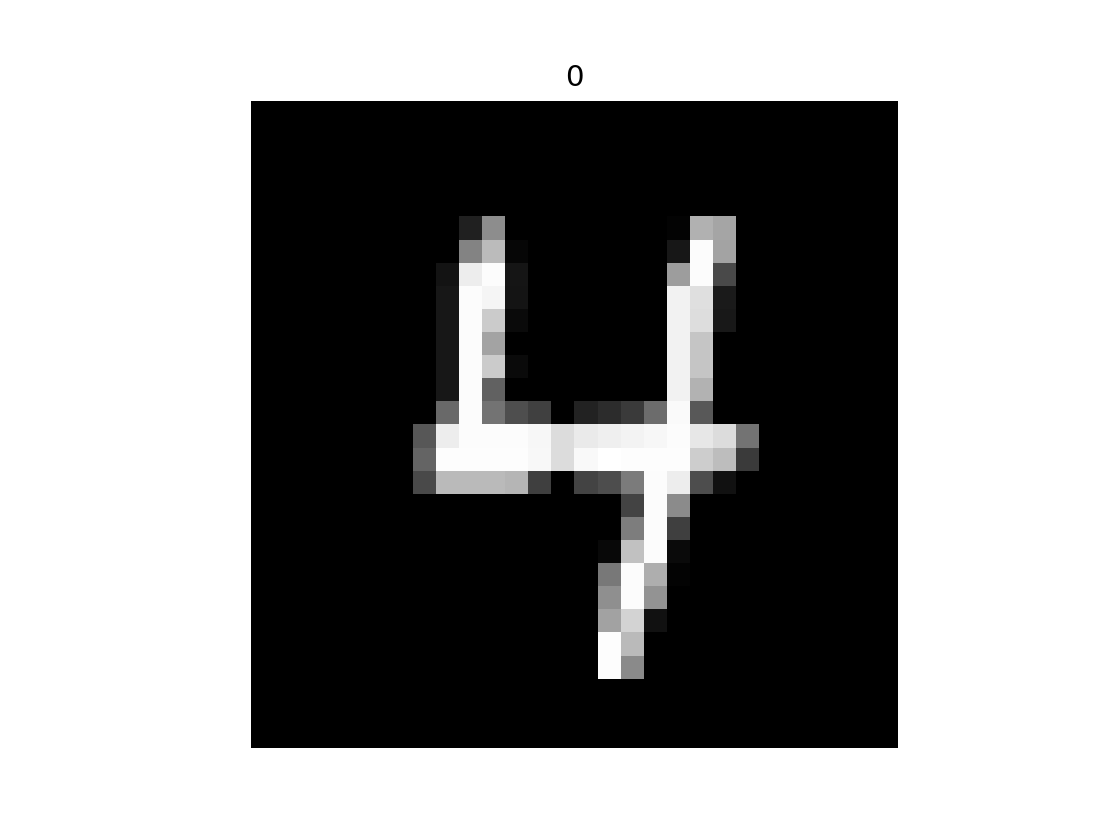

In [232]:
# visualize data

def vis(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()

vis_idx = 0
vis(X_val[vis_idx].reshape(-1, 28), y_val[vis_idx])

In [234]:
print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

# add some layers
# YOUR CODE HERE
model.add_layer(Linear(784, 784))
model.add_layer(ReLU())
model.add_layer(Linear(784, 256))
model.add_layer(ReLU())
model.add_layer(Linear(256, 128))
model.add_layer(ReLU())
model.add_layer(Linear(128, 32))
model.add_layer(ReLU())
model.add_layer(Linear(32, 10))

model = train(model, X_train , y_train, minibatch_size=128, epoch=10,
           learning_rate=0.001, X_val=X_val, y_val=y_val)




(52500, 784)
(17500, 784)


  1%|▊                                                                                 | 4/411 [00:00<00:12, 33.90it/s]

Epoch 1


  1%|▌                                                                                 | 3/411 [00:00<00:14, 28.88it/s]

Loss = 1.67663478174711 | Training Accuracy = 0.8811809523809524 | Val Loss = 0.5301954186938309 | Val Accuracy = 0.8734857142857143
Epoch 2


  1%|▌                                                                                 | 3/411 [00:00<00:14, 27.82it/s]

Loss = 0.6927575247544493 | Training Accuracy = 0.955695238095238 | Val Loss = 0.4541275369426771 | Val Accuracy = 0.9434857142857143
Epoch 3


  1%|▊                                                                                 | 4/411 [00:00<00:12, 31.35it/s]

Loss = 0.5879988325400263 | Training Accuracy = 0.9678285714285715 | Val Loss = 0.44870958581198966 | Val Accuracy = 0.9531428571428572
Epoch 4


  1%|▌                                                                                 | 3/411 [00:00<00:13, 29.96it/s]

Loss = 0.5413346524953595 | Training Accuracy = 0.9729142857142857 | Val Loss = 0.4399118159141149 | Val Accuracy = 0.9561714285714286
Epoch 5


  1%|▌                                                                                 | 3/411 [00:00<00:13, 29.94it/s]

Loss = 0.5100418876216953 | Training Accuracy = 0.9770095238095238 | Val Loss = 0.4350507540352505 | Val Accuracy = 0.9568
Epoch 6


  1%|▌                                                                                 | 3/411 [00:00<00:14, 27.69it/s]

Loss = 0.48788438437678017 | Training Accuracy = 0.9831619047619048 | Val Loss = 0.4322764711963383 | Val Accuracy = 0.9606857142857143
Epoch 7


  1%|▌                                                                                 | 3/411 [00:00<00:16, 24.89it/s]

Loss = 0.47262915216023776 | Training Accuracy = 0.9870285714285715 | Val Loss = 0.4282419723870969 | Val Accuracy = 0.9618285714285715
Epoch 8


  1%|▌                                                                                 | 3/411 [00:00<00:14, 28.22it/s]

Loss = 0.4607135632886437 | Training Accuracy = 0.9865333333333334 | Val Loss = 0.4254358314200105 | Val Accuracy = 0.9610285714285715
Epoch 9


  1%|▌                                                                                 | 3/411 [00:00<00:16, 25.33it/s]

Loss = 0.45076149272683447 | Training Accuracy = 0.9876190476190476 | Val Loss = 0.4278407112010428 | Val Accuracy = 0.9606285714285714
Epoch 10


100%|████████████████████████████████████████████████████████████████████████████████| 137/137 [00:02<00:00, 63.75it/s]


Loss = 0.4382176993096982 | Training Accuracy = 0.9910666666666667 | Val Loss = 0.4216614496937849 | Val Accuracy = 0.9627428571428571


<IPython.core.display.Javascript object>


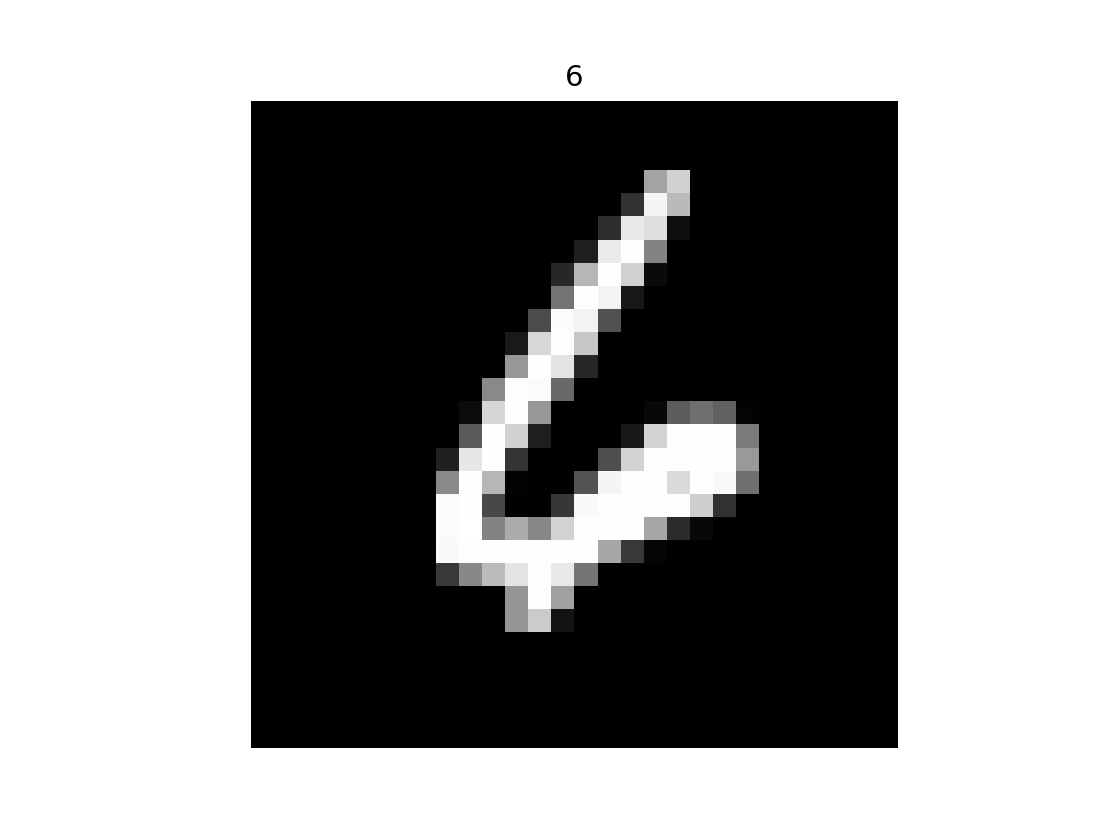

In [246]:
# visualize prediction 
vis_idx = 16
pred = model.predict(X_val)
vis(X_val[vis_idx].reshape(-1, 28), pred[vis_idx])

# TODO:
1) Add computational graph instead of list, model saving/loading, more optimizers, shedulers loss functions, operations, gpu support, utility tools ...

... Or simply use Pytorch/TF/whatever